# Analysing outputs

In [1]:
%matplotlib inline
import numpy as np
import cPickle
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import cPickle
import seaborn as sns
import tabulate
import pyprind
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, "../src")

from model.cnn import CNNProj
from model.zsn import ZSN
from space.space import Space

d:\tools\miniconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using gpu device 0: GeForce GT 630M (CNMeM is disabled)


## Load and subset data

In [2]:
"""
Testing simple CNN
"""

# Load data
data = cPickle.load(open("../data/cifar100_with_vec.pkl", "r"))
(X_train, Y_train, V_train), (X_test, Y_test, V_test) = data["data"]
labels = data["labels"]

# Initialize model
X_shape = X_train.shape[1:]
Xim_shape = 200
V_shape = 50

# Load embedding space
emb = Space("../data/glove.6B." + str(V_shape) + "d.txt")

# Prepare classes
# 10 known classes for large CNN
known = [
    "mountain",
    "lion",
    "chimpanzee",
    "house",
    "bicycle",
    "crocodile",
    "whale",
    "rocket",
    "tractor",
    "train"
]

def subset_data(network):
    """
    Subset data for training network
    """

    known_indices = map(labels.index, network.classes)

    known_classes_train_indices = np.in1d(Y_train, known_indices)
    known_classes_test_indices = np.in1d(Y_test, known_indices)

    Y_train_sub = Y_train[known_classes_train_indices, :]
    Y_test_sub = Y_test[known_classes_test_indices, :]
    X_train_sub = np.copy(X_train[known_classes_train_indices, :])
    X_test_sub = np.copy(X_test[known_classes_test_indices, :])
    V_train_sub = V_train[known_classes_train_indices, :]
    V_test_sub = V_test[known_classes_test_indices, :]

    X_train_sub = X_train_sub.astype("float32")
    X_test_sub = X_test_sub.astype("float32")
    X_train_sub /= 255
    X_test_sub /= 255

    Y_train_sub_new = [known_indices.index(i) for i in Y_train_sub]
    Y_test_sub_new = [known_indices.index(i) for i in Y_test_sub]

    Y_train_sub_new_c = np_utils.to_categorical(Y_train_sub_new, len(known_indices))
    Y_test_sub_new_c = np_utils.to_categorical(Y_test_sub_new, len(known_indices))

    return {
        "X_train": X_train_sub,
        "X_test": X_test_sub,
        "Y_train": Y_train_sub_new_c,
        "Y_test": Y_test_sub_new_c,
        "V_train": V_train_sub,
        "V_test": V_test_sub
    }

In [3]:
# Create an ensemble
cnns = [
    CNNProj("mountain_lion", known[:2], X_shape, 200, 2, V_shape),
    CNNProj("chimp_house", known[2:4], X_shape, 200, 2, V_shape),
    CNNProj("bicycle_croc", known[4:6], X_shape, 200, 2, V_shape),
    CNNProj("whale_rocket", known[6:8], X_shape, 200, 2, V_shape),
    CNNProj("tractor_train", known[8:], X_shape, 200, 2, V_shape)
]

## Train networks

In [4]:
for net in cnns:
    sub = subset_data(net)
    print("Training '" + net.name + "'")
#     net.train(sub["X_train"], sub["Y_train"], sub["V_train"], [200, 200], [40, 400])
#     net.model.save_weights("../data/" + net.name)
#     net.proj.model.save_weights("../data/" + net.name + "_proj")
    net.model.load_weights("../data/" + net.name)
    net.proj.model.load_weights("../data/" + net.name + "_proj")


    # Print accuracies
#     print("Accuracies")
#     print(net.accuracies(sub["X_train"],
#                          sub["Y_train"],
#                          sub["V_train"],
#                          sub["X_test"],
#                          sub["Y_test"],
#                          sub["V_test"]))


# Create inference system
zsn = ZSN(cnns, emb)

Training 'mountain_lion'
Accuracies
200/200 [==============================] - 0s     
{'Training accuracy (embedding)': 0.80900000000000005, 'Testing accuracy': 0.95999999999999996, 'Training accuracy': 0.97999999999999998, 'Testing accuracy (embedding)': 0.84999999999999998}
Training 'chimp_house'
Accuracies
200/200 [==============================] - 0s     
{'Training accuracy (embedding)': 0.59299999999999997, 'Testing accuracy': 0.92500000000000004, 'Training accuracy': 0.92900000000000005, 'Testing accuracy (embedding)': 0.56999999999999995}
Training 'bicycle_croc'
Accuracies
200/200 [==============================] - 0s     
{'Training accuracy (embedding)': 0.35199999999999998, 'Testing accuracy': 0.77000000000000002, 'Training accuracy': 0.77200000000000002, 'Testing accuracy (embedding)': 0.38}
Training 'whale_rocket'
Accuracies
200/200 [==============================] - 0s     
{'Training accuracy (embedding)': 0.92100000000000004, 'Testing accuracy': 0.86499999999999999, 'T

## Take vector outputs

In [7]:
# 5 unknown classes for zero shot prediction
unknown = [
    "lamp",
    "clock",
    "rose",
    "baby",
    "bridge"
]

# Generate zero shot testing data
unknown_indices = map(labels.index, unknown)
unknown_classes_train_indices = np.in1d(Y_train, unknown_indices)
unknown_classes_test_indices = np.in1d(Y_test, unknown_indices)
Y_unknown = np.concatenate([
    Y_train[unknown_classes_train_indices, :],
    Y_test[unknown_classes_test_indices, :]
], axis=0)
X_unknown = np.concatenate([
    X_train[unknown_classes_train_indices, :],
    X_test[unknown_classes_test_indices, :]
], axis=0)
X_unknown = X_unknown.astype("float32")
X_unknown /= 255
Y_unknown_labels = [labels[i] for i in Y_unknown]
V_unknown = np.concatenate([
    V_train[unknown_classes_train_indices, :],
    V_test[unknown_classes_test_indices, :]
], axis=0)

d:\tools\miniconda\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [8]:
output = zsn.evaluate_zero_shot_vector(X_unknown, V_unknown)
cPickle.dump(output, open("../data/vec_out", "w"))
# output = cPickle.load(open("../data/vec_out"))
glob = np.array(output[0])
indi = np.array(output[1])
stack = np.array(output[2])

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 508.703 sec


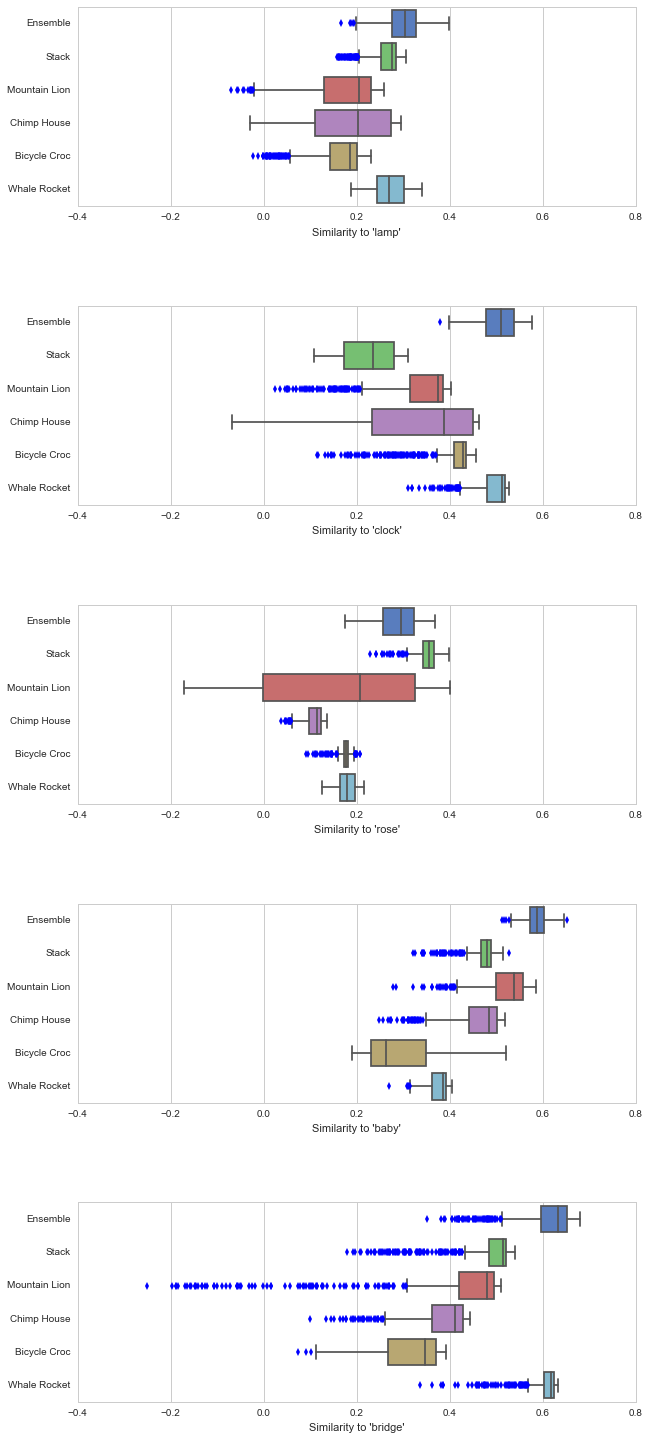

In [51]:
# Plot histograms
f, axarr = plt.subplots(5, figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

sns.set(style="whitegrid", palette="muted")

for i in xrange(5):
    indices = np.array(Y_unknown_labels) == unknown[i]
    sns.boxplot(data=np.concatenate([glob[indices][:, None],
#                                      stack[indices][:, None],
                                     indi[:, indices].T], axis=1), ax=axarr[i], orient="h")
    axarr[i].set_xlim(-0.4, 0.8)
    axarr[i].set_xlabel("Similarity to '" + unknown[i] + "'")
    axarr[i].set_yticklabels(["Ensemble", "Stack"] + [c.name.replace("_", " ").title() for c in zsn.cnns]);

plt.savefig("./plots/box.pdf")

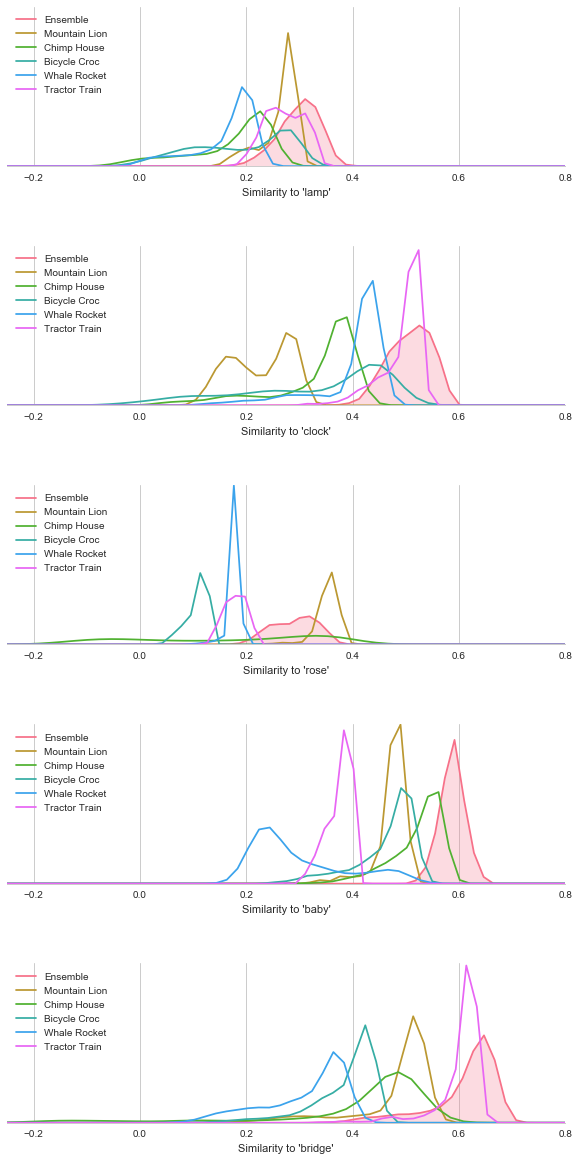

In [53]:
# Plot histograms
f, axarr = plt.subplots(5, figsize=(10, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

sns.set(style="whitegrid", palette="husl")
sns.despine(left=True)

for i in xrange(5):
    indices = np.array(Y_unknown_labels) == unknown[i]
    sns.distplot(glob[indices], hist=False, kde_kws={"shade": True}, ax=axarr[i], label="Ensemble")
#     sns.distplot(stack[indices], hist=False, kde_kws={"shade": True}, ax=axarr[i], label="Stack")
    sns.distplot(indi[0, indices], hist=False, kde_kws={"shade": False}, ax=axarr[i], label=zsn.cnns[0].name.replace("_", " ").title());
    sns.distplot(indi[1, indices], hist=False, kde_kws={"shade": False}, ax=axarr[i], label=zsn.cnns[1].name.replace("_", " ").title());
    sns.distplot(indi[2, indices], hist=False, kde_kws={"shade": False}, ax=axarr[i], label=zsn.cnns[2].name.replace("_", " ").title());
    sns.distplot(indi[3, indices], hist=False, kde_kws={"shade": False}, ax=axarr[i], label=zsn.cnns[3].name.replace("_", " ").title());
    sns.distplot(indi[4, indices], hist=False, kde_kws={"shade": False}, ax=axarr[i], label=zsn.cnns[4].name.replace("_", " ").title());
    axarr[i].set_xlim(-0.25,0.8)
    axarr[i].set_yticks([])
    axarr[i].set_xlabel("Similarity to '" + unknown[i] + "'")
    axarr[i].legend(loc="upper left")
    
plt.savefig("./plots/dist.pdf")

## Hit@k things

In [9]:
def show_hit_k(idx, k):
    """
    Show hit at k list and the image
    """
    
    plt.figure(figsize=(1, 1))
    plt.grid("off")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.swapaxes(np.swapaxes(X_unknown[idx], 0, 2), 0, 1))
    plt.show()
    res = zsn.predict(X_unknown[idx])
    
    def _name(i):
        return zsn.cnns[i].name.replace("_", " ").title()
    
    table = []
    
    table.append(["Ensemble"] + zsn.space.get_nearest_words(res["vec"], k).tolist())
#     table.append(["Stack"] + zsn.space.get_nearest_words(res["stack_vec"], k).tolist())
    for i in xrange(len(zsn.cnns)):
        table.append([_name(i)] + zsn.space.get_nearest_words(res["indi_vec"][i], k).tolist())
    print(tabulate.tabulate(table, tablefmt="fancy_grid", headers=["Network"]+["" for i in xrange(k)]))

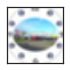

╒═══════════════╤══════════╤═══════════╤════════════╤══════════╤═══════════╤═══════════╤═══════════╤════════╤═══════════╕
│ Network       │          │           │            │          │           │           │           │        │           │
╞═══════════════╪══════════╪═══════════╪════════════╪══════════╪═══════════╪═══════════╪═══════════╪════════╪═══════════╡
│ Ensemble      │ train    │ boat      │ bus        │ along    │ car       │ mountain  │ truck     │ ride   │ near      │
├───────────────┼──────────┼───────────┼────────────┼──────────┼───────────┼───────────┼───────────┼────────┼───────────┤
│ Mountain Lion │ mountain │ mountains │ valley     │ hills    │ foothills │ desert    │ slopes    │ ridge  │ canyon    │
├───────────────┼──────────┼───────────┼────────────┼──────────┼───────────┼───────────┼───────────┼────────┼───────────┤
│ Chimp House   │ house    │ office    │ new        │ capitol  │ building  │ manhattan │ room      │ senate │ laid      │
├───────────────┼───────

In [18]:
show_hit_k(7, 9)

## Scatter plot thing

In [11]:
def scatter_pca(lbl):
    """
    Scatter for given class with PCA
    """
    
    ids = np.array(Y_unknown_labels) == lbl
    X = X_unknown[ids]
    
    orig = V_unknown[Y_unknown_labels.index(lbl)][None, :]
    ens = np.zeros((X.shape[0], 50))
    stk = np.zeros(ens.shape)
    tmp1 = np.zeros(ens.shape)
    tmp2 = np.zeros(ens.shape)
    tmp3 = np.zeros(ens.shape)
    tmp4 = np.zeros(ens.shape)
    tmp5 = np.zeros(ens.shape)
    
    bar = pyprind.ProgBar(X.shape[0])
    for idx, item in enumerate(X):
        res = zsn.predict(item)
        ens[idx, :] = res["vec"]
        stk[idx, :] = res["stack_vec"]
        tmp1[idx, :] = res["indi_vec"][0]
        tmp2[idx, :] = res["indi_vec"][1]
        tmp3[idx, :] = res["indi_vec"][2]
        tmp4[idx, :] = res["indi_vec"][3]
        tmp5[idx, :] = res["indi_vec"][4]
        bar.update()
        
    sc = PCA(n_components=2).fit_transform(np.concatenate([orig, ens, stk, tmp1, tmp2, tmp3, tmp4, tmp5]))
    orig = sc[0, :]
    return [orig, np.split(sc[1:, :], 7)]

In [12]:
baby = scatter_pca("baby")
bridge = scatter_pca("bridge")
rose = scatter_pca("rose")
clock = scatter_pca("clock")
lamp = scatter_pca("lamp")

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 63.599 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 67.564 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 74.090 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 82.941 sec
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 87.472 sec


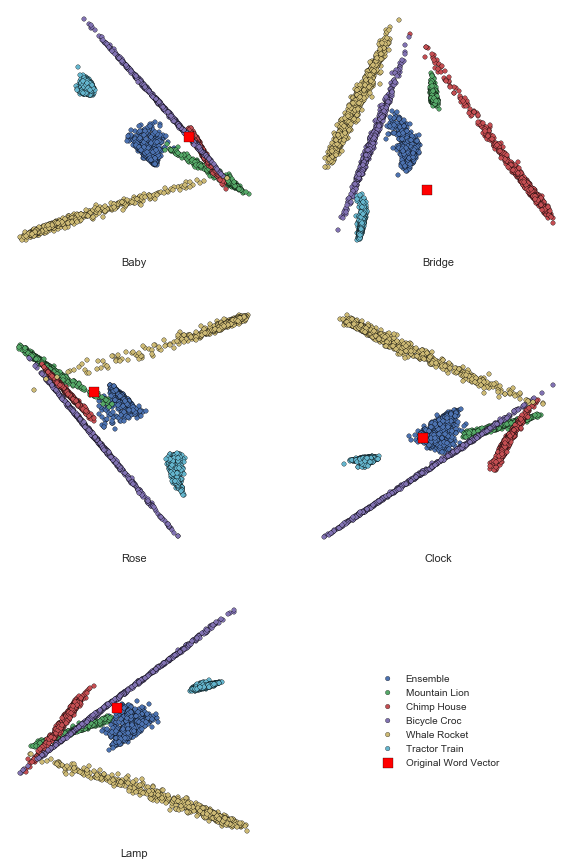

In [14]:
# Plot histograms
f, axarr = plt.subplots(3, 2, figsize=(10, 15))
cp = sns.color_palette("deep")
sns.set(style="white")
sns.despine(left=True, bottom=True)

items = [[baby, bridge], [rose, clock], [lamp]]
labs = [["Baby", "Bridge"], ["Rose", "Clock"], ["Lamp"]]

for i in xrange(2):
    for j in xrange(2):
        axarr[i][j].set_xticks([])
        axarr[i][j].set_yticks([])
        axarr[i][j].scatter(items[i][j][1][0][:, 0], items[i][j][1][0][:, 1], c=cp[0])
        axarr[i][j].scatter(items[i][j][1][2][:, 0], items[i][j][1][2][:, 1], c=cp[1])
        axarr[i][j].scatter(items[i][j][1][3][:, 0], items[i][j][1][3][:, 1], c=cp[2])
        axarr[i][j].scatter(items[i][j][1][4][:, 0], items[i][j][1][4][:, 1], c=cp[3])
        axarr[i][j].scatter(items[i][j][1][5][:, 0], items[i][j][1][5][:, 1], c=cp[4])
        axarr[i][j].scatter(items[i][j][1][6][:, 0], items[i][j][1][6][:, 1], c=cp[5])
        axarr[i][j].scatter(items[i][j][0][0], items[i][j][0][1], c="r", s=100, marker="s")
        axarr[i][j].set_xlabel(labs[i][j])
       
i = 2
j = 0
axarr[i][j].set_xticks([])
axarr[i][j].set_yticks([])
axarr[i][j].scatter(items[i][j][1][0][:, 0], items[i][j][1][0][:, 1], c=cp[0])
axarr[i][j].scatter(items[i][j][1][2][:, 0], items[i][j][1][2][:, 1], c=cp[1])
axarr[i][j].scatter(items[i][j][1][3][:, 0], items[i][j][1][3][:, 1], c=cp[2])
axarr[i][j].scatter(items[i][j][1][4][:, 0], items[i][j][1][4][:, 1], c=cp[3])
axarr[i][j].scatter(items[i][j][1][5][:, 0], items[i][j][1][5][:, 1], c=cp[4])
axarr[i][j].scatter(items[i][j][1][6][:, 0], items[i][j][1][6][:, 1], c=cp[5])
axarr[i][j].scatter(items[i][j][0][0], items[i][j][0][1], c="r", s=100, marker="s")
axarr[i][j].set_xlabel(labs[i][j])

i = 2
j = 1
axarr[i][j].set_xticks([])
axarr[i][j].set_yticks([])
axarr[i][j].scatter([], [], c=cp[0], label="Ensemble")
axarr[i][j].scatter([], [], c=cp[1], label="Mountain Lion")
axarr[i][j].scatter([], [], c=cp[2], label="Chimp House")
axarr[i][j].scatter([], [], c=cp[3], label="Bicycle Croc")
axarr[i][j].scatter([], [], c=cp[4], label="Whale Rocket")
axarr[i][j].scatter([], [], c=cp[5], label="Tractor Train")
axarr[i][j].scatter([], [], c="r", s=100, marker="s", label="Original Word Vector")
axarr[i][j].legend(loc="center")

plt.savefig("./plots/scatter.pdf")